In [19]:
%load_ext autoreload
%autoreload 2

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:\Brain_Network\Data\Allen_Institute_Dataset/manifest.json'
elif platform=='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
else:
    print('Add new computer system settings.')

import numpy as np; np.set_printoptions(linewidth=110); print(np.get_printoptions()['linewidth'])
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn
import scipy
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
import seaborn
from itertools import permutations 

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import (
    EcephysSession, 
    removed_unused_stimulus_presentation_columns
)
from allensdk.brain_observatory.ecephys.visualization import (
    plot_mean_waveforms, 
    plot_spike_counts, 
    raster_plot)
from allensdk.brain_observatory.visualization import plot_running_speed

# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

import data_visualizer
import data_model
import hierarchical_model
import util
import smoothing_spline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
110


In [3]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
print(cache.get_all_session_types())


Download time: 291600
['brain_observatory_1.1', 'functional_connectivity']


In [4]:
session_id = 791319847  # 715093703 791319847 754829445 771990200
session = cache.get_session_data(session_id)


# Extract data from multiple brain areas

# Hierarchical model inference

In [51]:
# model = data_model.AllenInstituteDataModel(session)
model = hierarchical_model.HierarchicalModel(session)
fit_model = smoothing_spline.SmoothingSpline()

### Select neurons by regions

In [6]:
probes = ['probeC', 'probeE']
selected_units = session.units[
    session.units['ecephys_structure_acronym'].isin(util.VISUAL_AREA) & 
    session.units['probe_description'].isin(probes)]

display(selected_units.shape)
display(selected_units[selected_units['probe_description'] == probes[0]].shape)
display(selected_units[selected_units['probe_description'] == probes[1]].shape)

# display(selected_units.head())
# display(selected_units.tail())

(136, 89)

(93, 89)

(43, 89)

### Select conditions

In [7]:
orientation = [270,]  # 'null'
temporal_frequency = [8.,]  # 'null'

stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_indices = stimulus_table[
    stimulus_table['orientation'].isin(orientation) & 
    stimulus_table['temporal_frequency'].isin(temporal_frequency)].index.values
# trials_indices = stimulus_table[
#     (stimulus_table['orientation']==orientation)].index.values

print('num trials:', len(trials_indices))

num trials: 15


### Get spike trains.

In [8]:
trial_time_window=[0.0, 2.1]
dt=0.002
spike_train_time_line = np.arange(trial_time_window[0], trial_time_window[1], dt)

spike_trains = model.get_trial_metric_per_unit_per_trial(
        stimulus_presentation_ids=trials_indices,
        unit_ids=selected_units.index.values,
        trial_time_window=trial_time_window,
        metric_type='spike_trains',
        dt=dt)

display(spike_trains.shape)
display(spike_trains.iloc[0, 0].shape)
display(spike_train_time_line.shape)

# display(spike_trains.head())

(136, 15)

(1050,)

(1050,)

## Initial step: group using spike count correlation.

In [9]:
spike_counts = model.get_trial_metric_per_unit_per_trial(
        stimulus_presentation_ids=trials_indices,
        unit_ids=selected_units.index.values,
        trial_time_window=[0.0, 2.1],
        metric_type='count')
display(spike_counts.shape)
# display(spike_counts.head())


(136, 15)

Plot the correlation matrix.

In [10]:
# corr_matrix = spike_counts.T.corr()
# visualizer = data_visualizer.AllenInstituteDataVisualizer(session)
# visualizer.plot_matrix_by_areas(
#     corr_matrix,
#     fig_title='test')

In [31]:
corr_matrix = spike_counts.T.corr()
sub_group_df = model.seperate_probe_pairs_units_by_corr_matrix(
    corr_matrix, corr_threshold=0.35, quantile=0.60)

# display(sub_group_df)
display(sub_group_df['group_id'].values)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [12]:

# psth_dict = model.get_across_sub_areas_metrics(
#     sub_group_df,
#     stimulus_presentation_ids=trials_indices,
#     trial_time_window=[0, 2.],
#     metric_type='psth',
#     dt=0.005,
#     smooth_sigma=2)

# visualizer = data_visualizer.AllenInstituteDataVisualizer(session)
# tables = [psth_dict[('probeC', 'probeE')][0], 
#           psth_dict[('probeE', 'probeC')][0],]

# visualizer.plot_tables(
#     tables,
# #     output_figure_path=project_folder+'test/C_E_pair_45_8_T2T_psth.pdf'
# )

### initial f^local-pop_g,a,c

In [35]:
sub_group_df = model.seperate_probe_pairs_units_by_corr_matrix(
    corr_matrix, corr_threshold=0.35, quantile=0.60)
unit_count = spike_counts.sum(axis=1)

for probe_pair in list(permutations(probes, 2)): 
    print(probe_pair)

    units_local_pop = sub_group_df[
        (sub_group_df['probe_from'] == probe_pair[0]) & 
        (sub_group_df['probe_to'] == probe_pair[1]) & 
        (sub_group_df['group_id'] == 1)].index.values

    count_threshold = np.quantile(unit_count.loc[units_local_pop].values, 0.75)
    active_units = unit_count.loc[units_local_pop][unit_count > count_threshold]
    idle_units = unit_count.loc[units_local_pop][unit_count <= count_threshold]
    sub_group_df.loc[idle_units.index.values, 'group_id'] = 2

    print('Area', units_local_pop.shape)
    print(active_units.shape)
    print(idle_units.shape)

display(sub_group_df['group_id'].values)


('probeC', 'probeE')
Area (56,)
(14,)
(42,)
('probeE', 'probeC')
Area (26,)
(7,)
(19,)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2])

A area active and idle groups

0 24153.67730615593
Total iterations: 36


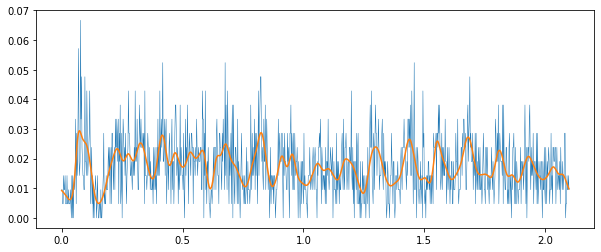

0 63716.122132488475
Total iterations: 29


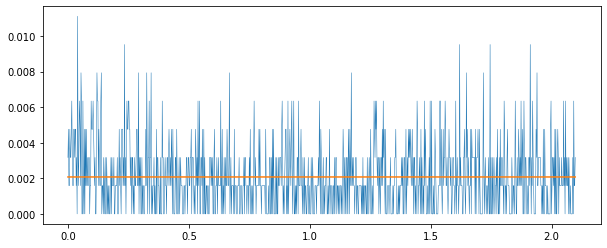

In [39]:

active_units = sub_group_df[
    (sub_group_df['probe_from'] == probe0) & 
    (sub_group_df['probe_to'] == probe1) & 
    (sub_group_df['group_id'] == 1)].index.values
idle_units = sub_group_df[
    (sub_group_df['probe_from'] == probe0) & 
    (sub_group_df['probe_to'] == probe1) & 
    (sub_group_df['group_id'] == 2)].index.values

Y_g_a_c = spike_trains.loc[active_units, trials_indices]
Y_g_a_c = np.stack(Y_g_a_c.values.flatten('F'), axis=0)

log_lmbda_hat_A1, _ = fit_model.poisson_regression_smoothing_spline(
    Y_g_a_c, spike_train_time_line, 
    lambda_tuning=1e-8, verbose=True)

plt.figure(figsize=(10, 4))
plt.plot(spike_train_time_line, Y_g_a_c.mean(axis=0), linewidth=0.5)
plt.plot(spike_train_time_line, np.exp(log_lmbda_hat_A1))
# plt.ylim(0, 0.08)
plt.show()


Y_g_a_c = spike_trains.loc[idle_units, trials_indices]
Y_g_a_c = np.stack(Y_g_a_c.values.flatten('F'), axis=0)

log_lmbda_hat_A2, _ = fit_model.poisson_regression_smoothing_spline(
    Y_g_a_c, spike_train_time_line, 
    constant_fit=True, lambda_tuning=1e-8, verbose=True)

plt.figure(figsize=(10, 4))
plt.plot(spike_train_time_line, Y_g_a_c.mean(axis=0), linewidth=0.5)
plt.plot(spike_train_time_line, np.exp(log_lmbda_hat_A2))
# plt.ylim(0, 0.08)
plt.show()


B area active and idle group

0 18409.540781775184
Total iterations: 34


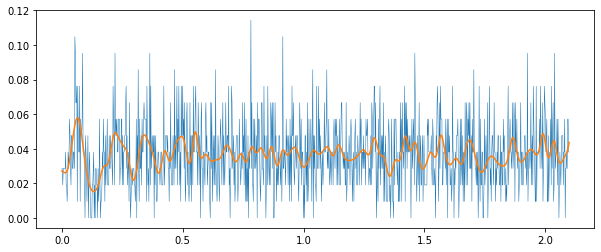

0 30243.57869965279
Total iterations: 27


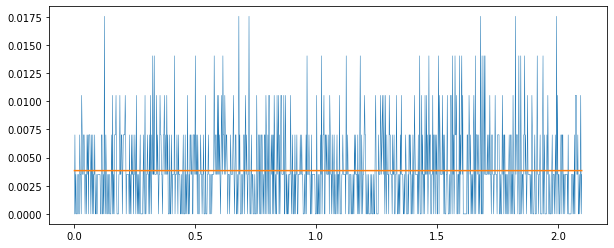

In [38]:

active_units = sub_group_df[
    (sub_group_df['probe_from'] == probe1) & 
    (sub_group_df['probe_to'] == probe0) & 
    (sub_group_df['group_id'] == 1)].index.values
idle_units = sub_group_df[
    (sub_group_df['probe_from'] == probe1) & 
    (sub_group_df['probe_to'] == probe0) & 
    (sub_group_df['group_id'] == 2)].index.values

Y_g_a_c = spike_trains.loc[active_units, trials_indices]
Y_g_a_c = np.stack(Y_g_a_c.values.flatten('F'), axis=0)

log_lmbda_hat_B1, _ = fit_model.poisson_regression_smoothing_spline(
    Y_g_a_c, spike_train_time_line, 
    lambda_tuning=1e-8, verbose=True)

plt.figure(figsize=(10, 4))
plt.plot(spike_train_time_line, Y_g_a_c.mean(axis=0), linewidth=0.5)
plt.plot(spike_train_time_line, np.exp(log_lmbda_hat_B1))
# plt.ylim(0, 0.08)
plt.show()


Y_g_a_c = spike_trains.loc[idle_units, trials_indices]
Y_g_a_c = np.stack(Y_g_a_c.values.flatten('F'), axis=0)

log_lmbda_hat_B2, _ = fit_model.poisson_regression_smoothing_spline(
    Y_g_a_c, spike_train_time_line, 
    constant_fit=True, lambda_tuning=1e-8, verbose=True)

plt.figure(figsize=(10, 4))
plt.plot(spike_train_time_line, Y_g_a_c.mean(axis=0), linewidth=0.5)
plt.plot(spike_train_time_line, np.exp(log_lmbda_hat_B2))
# plt.ylim(0, 0.08)
plt.show()


In [52]:
f_pop_cag = np.zeros((1, 2, 3, len(log_lmbda_hat_B2)))
# f_pop_cag[0, 0, 0] = 
f_pop_cag[0, 0, 1] = log_lmbda_hat_A1
f_pop_cag[0, 0, 2] = log_lmbda_hat_A2

# f_pop_cag[0, 1, 0] = 
f_pop_cag[0, 1, 1] = log_lmbda_hat_B1
f_pop_cag[0, 1, 2] = log_lmbda_hat_B2

model.f_pop_cag = f_pop_cag

print(model.f_pop_cag.shape)

(1, 2, 3, 1050)


In [23]:
# visualizer.plot_psth_per_unit(
#     spike_train_time_line, trials_indices, units_local_pop_A)

# plt.figure(figsize=(12, 8))
# seaborn.heatmap(spike_counts.T)
# plt.show()

# plt.figure()
# plt.hist(unit_count, bins=20)
# plt.show()

### Initialize $q_{arc}$

In [57]:

# neurons from area A. group_id == 0 is for cross-pop neurons
units_cross_pop_0 = sub_group_df[
    (sub_group_df['probe_from'] == probe0) & 
    (sub_group_df['probe_to'] == probe1) & 
    (sub_group_df['group_id'] == 0)].index.values

# neurons from area B. group_id == 0 is for cross-pop neurons
units_cross_pop_1 = sub_group_df[
    (sub_group_df['probe_from'] == probe1) & 
    (sub_group_df['probe_to'] == probe0) & 
    (sub_group_df['group_id'] == 0)].index.values

# Spikes for each area. 
Y_a_r_c_0 = spike_trains.loc[units_cross_pop_0, trials_indices]
Y_a_r_c_1 = spike_trains.loc[units_cross_pop_1, trials_indices]

Y_a_r_c_0 = np.stack(Y_a_r_c_0.values.flatten('F'), axis=0)
Y_a_r_c_1 = np.stack(Y_a_r_c_1.values.flatten('F'), axis=0)

display(Y_a_r_c_0.shape)
display(Y_a_r_c_1.shape)
print(np.log(np.mean(Y_a_r_c_0)))
print(np.log(np.mean(Y_a_r_c_1)))

(555, 1050)

(255, 1050)

-4.390349461801182
-3.955923184303386


In [58]:
Y_a_r_c = []
for area_id, probe_pair in enumerate(list(permutations(probes, 2))):
    units_cross_pop = sub_group_df[
        (sub_group_df['probe_from'] == probe_pair[0]) & 
        (sub_group_df['probe_to'] == probe_pair[1]) & 
        (sub_group_df['group_id'] == 0)].index.values
    area_spikes = spike_trains.loc[units_cross_pop, trials_indices]
    area_spikes = np.stack(area_spikes.values.flatten('F'), axis=0)
    Y_a_r_c.append(area_spikes)
Y_a_r_c = np.vstack(Y_a_r_c)
print('Y_a_r_c.shape', Y_a_r_c.shape)
print(np.log(np.mean(Y_a_r_c)))

Y_a_r_c.shape (810, 1050)
-4.232249323700231


In [59]:
# r: trials_indices for one condition.
q_a_r_c = np.zeros([2, len(trials_indices), 1])

q_offset_0 = np.kron(q_a_r_c[0, :, 0].reshape(-1, 1), 
                     np.ones([len(units_cross_pop_0), 1]))
q_offset_1 = np.kron(q_a_r_c[1, :, 0].reshape(-1, 1), 
                     np.ones([len(units_cross_pop_1), 1]))
q_offset = np.vstack([q_offset_0, q_offset_1])

### Update f^cross_pop_a,r,c

0 55109.110861501904
Total iterations: 39
0 30935.05839776649
Total iterations: 35
0 86116.94939266136
Total iterations: 37


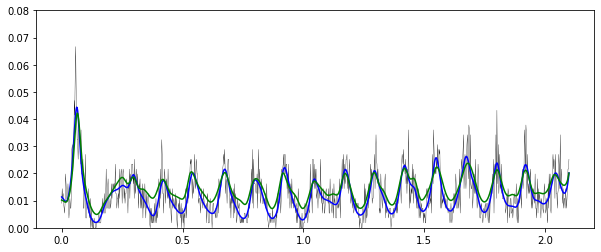

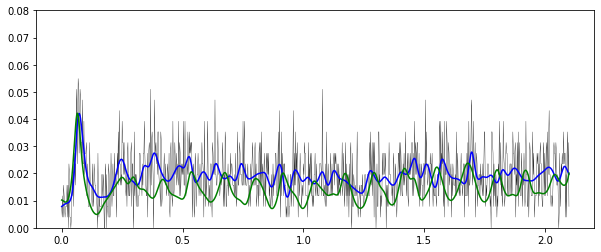

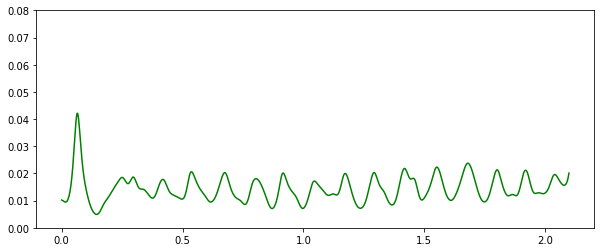

In [60]:


# log_lmbda_hat_0, _ = fit_model.poisson_regression_smoothing_spline(
#     Y_a_r_c_0, spike_train_time_line, lambda_tuning=1e-8, verbose=True)
# log_lmbda_hat_1, _ = fit_model.poisson_regression_smoothing_spline(
#     Y_a_r_c_1, spike_train_time_line, lambda_tuning=1e-8, verbose=True)
log_lmbda_hat_0, _ = fit_model.poisson_regression_smoothing_spline(
    Y_a_r_c_0, spike_train_time_line, 
    log_lambda_offset=q_offset_0, lambda_tuning=1e-8, verbose=True)
log_lmbda_hat_1, _ = fit_model.poisson_regression_smoothing_spline(
    Y_a_r_c_1, spike_train_time_line, 
    log_lambda_offset=q_offset_1, lambda_tuning=1e-8, verbose=True)
log_lmbda_hat_cross, _ = fit_model.poisson_regression_smoothing_spline(
    Y_a_r_c, spike_train_time_line, 
    log_lambda_offset=q_offset, lambda_tuning=1e-8, verbose=True)

model.f_pop_cag[0, 0, 0] = log_lmbda_hat_cross
model.f_pop_cag[0, 1, 0] = log_lmbda_hat_cross

plt.figure(figsize=(10, 4))
plt.plot(spike_train_time_line, Y_a_r_c_0.mean(axis=0), 'k', linewidth=0.3)
plt.plot(spike_train_time_line, np.exp(log_lmbda_hat_0), 'b')
plt.plot(spike_train_time_line, np.exp(log_lmbda_hat_cross), 'g')
plt.ylim(0, 0.08)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(spike_train_time_line, Y_a_r_c_1.mean(axis=0), 'k', linewidth=0.3)
plt.plot(spike_train_time_line, np.exp(log_lmbda_hat_1), 'b')
plt.plot(spike_train_time_line, np.exp(log_lmbda_hat_cross), 'g')
plt.ylim(0, 0.08)
plt.show()


plt.figure(figsize=(10, 4))
plt.plot(spike_train_time_line, np.exp(log_lmbda_hat_cross), 'g')
plt.ylim(0, 0.08)
plt.show()


### Update `q_arc`

In [64]:
c = 0
a = 0
log_lambda_offset = model.f_pop_cag[c,a,0]

units_cross_pop = sub_group_df[
    (sub_group_df['probe_from'] == probe0) & 
    (sub_group_df['probe_to'] == probe1) & 
    (sub_group_df['group_id'] == 0)].index.values
print('# Neurons', units_cross_pop.shape)

for r in range(len(trials_indices)):
    Y_a_r_c = spike_trains.loc[units_cross_pop, trials_indices[r]]
    Y_a_r_c = np.stack(Y_a_r_c.values.flatten('F'), axis=0)
    log_lmbda_hat, beta = model.fit_q_arc(
        Y_a_r_c, spike_train_time_line, 
        a, r, c,
        log_lambda_offset=log_lambda_offset,
        verbose=False)

a = 1
units_cross_pop = sub_group_df[
    (sub_group_df['probe_from'] == probe1) & 
    (sub_group_df['probe_to'] == probe0) & 
    (sub_group_df['group_id'] == 0)].index.values
print('# Neurons', units_cross_pop.shape)

for r in range(len(trials_indices)):
    Y_a_r_c = spike_trains.loc[units_cross_pop, trials_indices[r]]
    Y_a_r_c = np.stack(Y_a_r_c.values.flatten('F'), axis=0)
    log_lmbda_hat, beta = model.fit_q_arc(
        Y_a_r_c, spike_train_time_line, 
        a, r, c,
        log_lambda_offset=log_lambda_offset,
        verbose=False)

# plt.figure()
# plt.plot(spike_train_time_line, Y_a_r_c.mean(axis=0), 'k', linewidth=0.3)
# plt.plot(spike_train_time_line, np.exp(log_lmbda_hat + log_lambda_offset), 'b')
# plt.legend()
# # plt.ylim(-5,1)
# plt.show()

# Neurons (37,)
# Neurons (17,)


### Update $\mu, \Sigma$

In [65]:
q_arc_data = model.q_arc.reshape(2, -1)

# print(q_arc_data)
# print(q_arc_data.reshape(2, -1))

mu_cross_pop = np.mean(q_arc_data, axis=1)
q_arc_data_normed = q_arc_data - mu_cross_pop.reshape(2, -1)
sigma_cross_pop = 1 / (len(trials_indices) - 1) * q_arc_data_normed @ q_arc_data_normed.T

print('mu_cross_pop')
print(mu_cross_pop)
print('sigma_cross_pop')
print(sigma_cross_pop)

rho = sigma_cross_pop[0, 1] / np.sqrt(sigma_cross_pop[0, 0] * sigma_cross_pop[1, 1])
print(rho)

mu_cross_pop
[-0.26844629  0.17001847]
sigma_cross_pop
[[0.22887372 0.19620325]
 [0.19620325 0.21687608]]
0.88064810754809


### Updating $z_{ngac}$ group assignment indicator

In [66]:

c = 0
a = 0

area_units = sub_group_df[
    (sub_group_df['probe_from'] == probe0) & 
    (sub_group_df['probe_to'] == probe1)]
area_units_ids = area_units.index.values
print('# Neurons', area_units.shape)

q_arc_data = model.q_arc
z_prob = np.zeros((len(area_units_ids), 3))

for n in range(len(area_units_ids)):
    Y_narc = spike_trains.loc[area_units_ids[n], trials_indices]
    Y_narc = np.stack(Y_narc.values.flatten('F'), axis=0)

    # cross-pop group NLL.
    g = 0
    log_lambda_offset = q_arc_data[a, :, c].reshape(len(trials_indices), 1)
    log_lmbd = model.f_pop_cag[c, a, g] + log_lambda_offset
    nll_cross_pop = model.spike_trains_neg_log_likelihood(log_lmbd, Y_narc)
    nll_cross_pop -= np.log(model.p_gac[g, a, c])

    # local-pop group 1 NLL.
    g = 1
    nll_local_pop_g1 = model.spike_trains_neg_log_likelihood(model.f_pop_cag[c, a, g], Y_narc)
    nll_local_pop_g1 -= np.log(model.p_gac[g, a, c])

    # local-pop group 2 NLL.
    g = 2
    nll_local_pop_g2 = model.spike_trains_neg_log_likelihood(model.f_pop_cag[c, a, g], Y_narc)
    nll_local_pop_g2 -= np.log(model.p_gac[g, a, c])

    z_prob[n] = [nll_cross_pop, nll_local_pop_g1, nll_local_pop_g2]

# print(z_prob)
z_group_indicator = np.argmin(z_prob, axis=1)
print(z_group_indicator)
print(area_units['group_id'].values)

sub_group_df.loc[area_units_ids, 'group_id'] = z_group_indicator


# Neurons (93, 3)
[2 0 2 1 0 2 2 0 0 0 0 0 0 0 0 1 0 0 2 0 1 2 0 2 0 2 2 2 0 1 2 0 2 0 2 0 2 2 2 0 0 1 2 0 2 2 1 1 0 2 2 0 2 2
 1 2 2 2 1 0 2 2 2 1 0 1 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 1 2 1 2 2 2 2 1 1 1 2 2 1 2 2
 1 2 2 2 1 2 2 2 2 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 2 2 2]


In [67]:

c = 0
a = 1

area_units = sub_group_df[
    (sub_group_df['probe_from'] == probe1) & 
    (sub_group_df['probe_to'] == probe0)]
area_units_ids = area_units.index.values
print('# Neurons', area_units.shape)

q_arc_data = model.q_arc
z_prob = np.zeros((len(area_units_ids), 3))

for n in range(len(area_units_ids)):
    Y_narc = spike_trains.loc[area_units_ids[n], trials_indices]
    Y_narc = np.stack(Y_narc.values.flatten('F'), axis=0)

    # cross-pop group NLL.
    g = 0
    log_lambda_offset = q_arc_data[a, :, c].reshape(len(trials_indices), 1)
    log_lmbd = model.f_pop_cag[c, a, g] + log_lambda_offset
    nll_cross_pop = model.spike_trains_neg_log_likelihood(log_lmbd, Y_narc)
    nll_cross_pop -= np.log(model.p_gac[g, a, c])

    # local-pop group 1 NLL.
    g = 1
    nll_local_pop_g1 = model.spike_trains_neg_log_likelihood(model.f_pop_cag[c, a, g], Y_narc)

    # local-pop group 2 NLL.
    g = 2
    nll_local_pop_g2 = model.spike_trains_neg_log_likelihood(model.f_pop_cag[c, a, g], Y_narc)

    z_prob[n] = [nll_cross_pop, nll_local_pop_g1, nll_local_pop_g2]

# print(z_prob)
z_group_indicator = np.argmin(z_prob, axis=1)
print(z_group_indicator)
print(area_units['group_id'].values)

sub_group_df.loc[area_units_ids, 'group_id'] = z_group_indicator


# Neurons (43, 3)
[2 0 0 2 2 2 0 0 1 2 0 0 1 2 0 2 1 2 2 0 2 2 2 2 2 2 2 1 2 0 1 0 1 1 2 2 2 2 2 2 2 0 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 1 2 2 2 2 2 2 2 1 2 1 1 1 1 1 2 2 2 2 2 2 2 2 2]


### Update $p_{ac}$

In [68]:
c = 0
a = 0
area_units = sub_group_df[
    (sub_group_df['probe_from'] == probe0) & 
    (sub_group_df['probe_to'] == probe1)]
area_units_ids = area_units.index.values
group_count = sub_group_df.loc[area_units_ids, 'group_id'].value_counts()
model.p_gac[group_count.index.values, a, c] = group_count.values / group_count.values.sum()

c = 0
a = 1
area_units = sub_group_df[
    (sub_group_df['probe_from'] == probe1) & 
    (sub_group_df['probe_to'] == probe0)]
area_units_ids = area_units.index.values
group_count = sub_group_df.loc[area_units_ids, 'group_id'].value_counts()
model.p_gac[group_count.index.values, a, c] = group_count.values / group_count.values.sum()


print(model.p_gac[:, :, c])

[[0.29032258 0.25581395]
 [0.15053763 0.1627907 ]
 [0.55913978 0.58139535]]
